# Data Prep

In [1]:
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/calogan_metrics.py
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/prd_score.py
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/score.py
! wget https://github.com/SchattenGenie/mlhep2019_2_phase/raw/master/analysis/embedder.tp
! wget https://github.com/SchattenGenie/mlhep2019_2_phase/raw/master/analysis/generator.py

--2021-11-22 02:57:17--  https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/calogan_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4115 (4.0K) [text/plain]
Saving to: ‘calogan_metrics.py’

calogan_metrics.py  100%[===================>]   4.02K  --.-KB/s    in 0s      

2021-11-22 02:57:17 (49.3 MB/s) - ‘calogan_metrics.py’ saved [4115/4115]

--2021-11-22 02:57:17--  https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/prd_score.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

new_data_path = '/content/gdrive/My Drive/mlhep2020_vae/CaloGAN_train_e_110000.npz'
test_new_path = '/content/gdrive/My Drive/mlhep2020_vae/CaloGAN_test_e_100000.npz'

Mounted at /content/gdrive/


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
from torchsummary import summary
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set()


def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Available device =", device)

Available device = cuda


In [4]:
from sklearn.model_selection import train_test_split 

np.random.seed(123)

new_data_train = np.load(new_data_path, allow_pickle=True)

EnergyDeposit, EnergyDepositTest, ParticleMomentum, ParticleMomentumTest, ParticlePoint, ParticlePointTest = train_test_split(
    new_data_train['EnergyDeposit'].reshape(-1, 1, 30, 30),
     new_data_train['ParticleMomentum'], 
     new_data_train['ParticlePoint'][:, :2], 
     test_size = 10000, 
     train_size = 100000)

EnergyDeposit = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint = torch.tensor(ParticlePoint).float()
EnergyDepositTest = torch.tensor(EnergyDepositTest).float()
ParticleMomentumTest = torch.tensor(ParticleMomentumTest).float()
ParticlePointTest = torch.tensor(ParticlePointTest).float()

In [5]:
BATCH_SIZE = 1024

calo_dataset = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint)
calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

calo_dataset_test = utils.TensorDataset(EnergyDepositTest, ParticleMomentumTest, ParticlePointTest)
calo_dataloader_test = torch.utils.data.DataLoader(calo_dataset_test, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

In [6]:
LATENT_DIM = 16
SHOW_PICS = 10
IMAGES_SHOW = np.random.randint(len(calo_dataloader_test.dataset), size=SHOW_PICS)

# Model and Loss

In [7]:
class VAE(nn.Module):
    def __init__(self, z_dim=LATENT_DIM):
        super(VAE, self).__init__()

        self.conv1a = nn.Conv2d(1,  32, 3, stride=1, padding=1)
        self.conv1 = nn.Conv2d( 32,   64, 3, stride=2, padding=1)
        # self.conv2a = nn.Conv2d(32,  64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d( 64,  128, 3, stride=2, padding=0)
        # self.conv3a = nn.Conv2d(64,  128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d( 128, 256, 3, stride=2, padding=0)
        # self.conv4a = nn.Conv2d(128,  256, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, stride=2, padding=0)

        self.en_bn1a = nn.BatchNorm2d(32)
        self.en_bn1 = nn.BatchNorm2d(64)
        self.en_bn2a = nn.BatchNorm2d(64)
        self.en_bn2 = nn.BatchNorm2d(128)
        self.en_bn3a = nn.BatchNorm2d(128)
        self.en_bn3 = nn.BatchNorm2d(256)
        self.en_bn4a = nn.BatchNorm2d(256)
        self.en_bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 + 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3a = nn.Linear(64, z_dim)
        self.fc3b = nn.Linear(64, z_dim)

        self.en_bnfc1 = nn.BatchNorm1d(128)
        self.en_bnfc2 = nn.BatchNorm1d(64)

        self.fc1t = nn.Linear(z_dim, z_dim * 2 * 2)
        self.fc2t = nn.Linear(z_dim * 2 * 2 + 5, z_dim * 2 * 2 * 4)
        self.fc3t = nn.Linear(z_dim * 2 * 2 * 4, z_dim * 2 * 2 * 8)

        self.bnfc1t = nn.BatchNorm1d(z_dim * 2 * 2)
        self.bnfc2t = nn.BatchNorm1d(z_dim * 2 * 2 * 4)
        self.bnfc3t = nn.BatchNorm1d(z_dim * 2 * 2 * 8)

        self.conv1t = nn.ConvTranspose2d(z_dim * 8, 128, 3, stride=2, padding=1, output_padding=1) 
        # self.conv1ta = nn.ConvTranspose2d(256, 128,  3, stride=1, padding=0, output_padding=0)
        self.conv2t = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1)
        # self.conv2ta = nn.ConvTranspose2d(128, 128,  3, stride=1, padding=0, output_padding=0)
        self.conv3t = nn.ConvTranspose2d(128, 64,  3, stride=2, padding=1, output_padding=1)
        # self.conv3ta = nn.ConvTranspose2d(64, 32,  3, stride=1, padding=0, output_padding=0)
        self.conv4t = nn.ConvTranspose2d(64, 32,  3, stride=2, padding=1, output_padding=1)
        self.conv4ta = nn.ConvTranspose2d(32, 1,  3, stride=1, padding=0, output_padding=0)

        self.bn1 = nn.BatchNorm2d(128)
        self.bn1a = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2a = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn3a = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)


    def encode(self, X, params):
        X = F.leaky_relu(self.en_bn1a(self.conv1a(X)))
        X = F.leaky_relu(self.en_bn1(self.conv1(X)))
        # X = F.leaky_relu(self.en_bn2a(self.conv2a(X)))
        X = F.leaky_relu(self.en_bn2(self.conv2(X)))
        # X = F.leaky_relu(self.en_bn3a(self.conv3a(X)))
        X = F.leaky_relu(self.en_bn3(self.conv3(X)))
        # X = F.leaky_relu(self.en_bn4a(self.conv4a(X)))
        X = F.leaky_relu(self.en_bn4(self.conv4(X)))

        X = X.reshape(-1,256)
        X = torch.cat([X, params], dim=1)
        X = F.leaky_relu(self.en_bnfc1(self.fc1(X)))
        X = F.leaky_relu(self.en_bnfc2(self.fc2(X)))
        return self.fc3a(X), self.fc3b(X)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, params):
        z = F.leaky_relu(self.bnfc1t(self.fc1t(z)))
        z = F.leaky_relu(self.bnfc2t(self.fc2t(torch.cat([z, params], dim=1))))
        z = F.leaky_relu(self.bnfc3t(self.fc3t(z)))
        z = z.view(-1, LATENT_DIM * 8, 2, 2)

        z = F.leaky_relu(self.bn1(self.conv1t(z)))
        # z = F.leaky_relu(self.bn1a(self.conv1ta(z)))
        # print(z.shape)
        z = F.leaky_relu(self.bn2(self.conv2t(z)))
        # z = F.leaky_relu(self.bn2a(self.conv2ta(z)))
        # print(z.shape)
        z = F.leaky_relu(self.bn3(self.conv3t(z)))
        # z = F.leaky_relu(self.bn3a(self.conv3ta(z)))
        # print(z.shape)
        z = F.leaky_relu(self.bn4(self.conv4t(z)))
        # z = F.relu(self.conv4t(z))
        z = F.relu(self.conv4ta(z))
        
        z = z[:,:,1:31,1:31]
        return z

    def forward(self, x, params):
        mu, logvar = self.encode(x, params)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, params), mu, logvar

In [8]:
def loss_function(recon_x, x, mu, logvar):
    RMSE = torch.sqrt(F.mse_loss(recon_x, x, reduction='sum'))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RMSE + KLD, RMSE.item(), KLD.item()

# Plotting Functions

In [9]:
def plot_energy_and_shower(energ_distr_real, energ_distr_generated):
    f, ax = plt.subplots(2,2, figsize=(8, 8))

    vmin = torch.max(energ_distr_real) 
    vmin = min(vmin, torch.min(energ_distr_generated))
    vmax = torch.max(energ_distr_real) 
    vmax = max(vmax, torch.max(energ_distr_generated))

    for i, distr_type, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        for j, distr_name in zip([0,1], ["energy distribution", "shower"]):
            ax[j][i].set_title (distr_type + " " + distr_name, fontsize=14)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
            ax[j][i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        ax[0][i].set_xlabel(r'$x$', fontsize=12)
        ax[0][i].set_ylabel(r'$y$', fontsize=12)
        ax[1][i].set_xlabel(r'Cluster traverse width ($x$)', fontsize=12)
        ax[1][i].set_ylabel(r'Arbitrary units (sum along $y$)', fontsize=12)

        ax[0][i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[0][i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[0][i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        # plot shower
        ax[1][i].bar(np.arange(0,30), torch.sum(en_dep, axis=0), 
                  width=1.0, align='edge', edgecolor='black')

        # plot energy distribution
        ax[0][i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
        im = ax[0][i].imshow(en_dep, origin = 'lower', cmap="inferno", 
                          vmin=vmin, vmax=vmax)

        # add colorabar for the energy distributions
        divider = make_axes_locatable(ax[0][i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label(r'$log_{10}$(1 + E)', rotation='270', va='top', labelpad=20)
    plt.subplots_adjust(wspace=0.6, hspace=0.4)
    #plt.show()
    return

In [10]:
def plot_epoch(epoch, init_pics, gen_pics, recon_pics, kl_train, kl_test, rmse_train, rmse_test, loss_train, loss_test, prd_auc_train, prd_auc_test):

    clear_output()

    fs_title = 14
    fs_axis = 12
    fs_ticks = 10

    f, ax = plt.subplots(2,2, figsize=(15, 15))

    ax[0][0].set_title ('Overall loss', fontsize=fs_title)
    ax[0][0].set_xlabel('Epoch',     fontsize=fs_axis)
    ax[0][0].set_ylabel('Loss',          fontsize=fs_axis)
    
    ax[0][0].set_xticks     (np.linspace(0.0, len(loss_test), 5))
    ax[0][0].set_xticklabels(np.linspace(0.0, epoch, 5))
    ax[0][0].plot(loss_train, label='train', color = 'red',  alpha=0.5)
    ax[0][0].plot(loss_test, label='test',     color = 'blue', alpha=0.5)
    ax[0][0].legend()

    ax[0][1].set_title ('KL divergence', fontsize=fs_title)
    ax[0][1].set_xlabel('Epoch',     fontsize=fs_axis)
    ax[0][1].set_ylabel('Loss',          fontsize=fs_axis)
    
    ax[0][1].set_xticks     (np.linspace(0.0, len(kl_train), 5))
    ax[0][1].set_xticklabels(np.linspace(0.0, epoch, 5))
    ax[0][1].plot(kl_train, label='train', color = 'red',  alpha=0.5)
    ax[0][1].plot(kl_test, label='test',     color = 'blue', alpha=0.5)
    ax[0][1].legend()

    ax[1][0].set_title ('Recon loss', fontsize=fs_title)
    ax[1][0].set_xlabel('Epoch',     fontsize=fs_axis)
    ax[1][0].set_ylabel('Loss',          fontsize=fs_axis)
    
    ax[1][0].set_xticks     (np.linspace(0.0, len(rmse_train), 5))
    ax[1][0].set_xticklabels(np.linspace(0.0, epoch, 5))
    ax[1][0].plot(rmse_train, label='train', color = 'red',  alpha=0.5)
    ax[1][0].plot(rmse_test, label='test',     color = 'blue', alpha=0.5)
    ax[1][0].legend()
    
    ax[1][1].set_xticks     (np.linspace(0.0, epoch, 5))
    ax[1][1].set_xticklabels(np.linspace(0.0, epoch, 5))
    ax[1][1].set_title ('PRD AUC', fontsize=fs_title)
    ax[1][1].set_xlabel('Epoch',   fontsize=fs_axis)
    ax[1][1].set_ylabel('PRD AUC', fontsize=fs_axis)
    ax[1][1].plot(prd_auc_train,     label="Training",  color='red')
    ax[1][1].plot(prd_auc_test, label="Test", color='blue')
    ax[1][1].legend()
    for i in range(len(init_pics)):
        plot_energy_and_shower(init_pics.detach().cpu()[i], gen_pics.detach().cpu()[i])
    plt.show()
    return

# Training

In [11]:
CALC_PRD = 50                
NUM_RUNS = 10
PRD_FREQ = 1

In [12]:
from calogan_metrics import get_physical_stats

def prd_auc(generated_example, real_example, reshape_size, ParticleMomentum_b, ParticlePoint_b):

    precision, recall = compute_prd_from_embedding(
                        real_example.reshape(len(real_example), -1), 
                        generated_example.reshape(len(generated_example), -1),
                        num_clusters=100,
                        num_runs=NUM_RUNS)
    
    auc_img = auc(precision, recall)
    
    physical_metrics_sol = get_physical_stats(
        real_example.reshape(-1, 30, 30), 
        ParticleMomentum_b,
        ParticlePoint_b)
    
    physical_metrics_pred = get_physical_stats(
        generated_example.reshape(-1, 30, 30), 
        ParticleMomentum_b,
        ParticlePoint_b)

    precision, recall = compute_prd_from_embedding(
        physical_metrics_sol, 
        physical_metrics_pred,
        num_clusters=100,
        num_runs=NUM_RUNS)
    
    auc_physical_metrics = auc(precision, recall)

    return min(auc_img, auc_physical_metrics)

In [13]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

def run_training(epochs):
    max_prd = 0
    best_state = model.state_dict()
    current_epoch = 0
    kl_train = []
    rmse_train = []
    loss_train = []
    prd_auc_train = []
    kl_test = []
    rmse_test = []
    loss_test = []
    prd_auc_test = []
    for epoch in tqdm(np.arange(current_epoch, epochs)):
        model.train()
        epoch_loss = 0
        kl_loss = 0
        rmse_loss = 0
        first = True
        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                ParticleMomentum_b.to(device), \
                ParticlePoint_b.to(device)
            # EnergyDeposit_b = bc.transform_to(EnergyDeposit_b)

            ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)
            data = EnergyDeposit_b  # , ParticleMomentum_ParticlePoint_b], dim=1)
            # data = bc.transform_to(bc.transform_to(data))
            # for batch_idx, (data, _) in enumerate(train_loader):
            # data = torch.log(data + 1) # log
            recon_batch, mu, logvar = model(data, ParticleMomentum_ParticlePoint_b)
            loss, rmse, kl = loss_function(recon_batch, data, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            kl_loss += kl / (len(calo_dataloader.dataset) // BATCH_SIZE + 1)
            rmse_loss += rmse / (len(calo_dataloader.dataset) // BATCH_SIZE + 1)
            epoch_loss += loss.item() / (len(calo_dataloader.dataset) // BATCH_SIZE + 1)
            
            optimizer.step()
            
            if first and current_epoch != 0 and current_epoch % PRD_FREQ == 0:
                noise = torch.tensor(np.random.normal(0,1,size=(len(ParticleMomentum_ParticlePoint_b), LATENT_DIM))).float().to(device)
                recon_batch = model.decode(noise, ParticleMomentum_ParticlePoint_b).detach()
                reshape_size = EnergyDeposit_b.shape[0] # = BATCH_SIZE or less
                # recon_batch = bc.transform_from(recon_batch)
                # recon_batch = torch.exp(recon_batch) - 1 #log
                prd_auc_train.append(prd_auc(recon_batch.detach().cpu().numpy(), EnergyDeposit_b.detach().cpu().numpy(), reshape_size, ParticleMomentum_b.detach().cpu().numpy(), ParticlePoint_b.detach().cpu().numpy()))
                first = False
        
        
        if current_epoch != 0:
            kl_train.append(kl_loss)
            rmse_train.append(rmse_loss)
            loss_train.append(epoch_loss)
    
        model.eval()
        epoch_loss = 0
        kl_loss = 0
        rmse_loss = 0
        first = True 
        with torch.no_grad():
            cur_prd_arr = []
            for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader_test:
                EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                    ParticleMomentum_b.to(device), \
                    ParticlePoint_b.to(device)
                ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)

                data = EnergyDeposit_b
                recon_batch, mu, logvar = model(data, ParticleMomentum_ParticlePoint_b)
                loss, rmse, kl = loss_function(recon_batch, data, mu, logvar)
                if first:
                    kl_loss += kl / (len(calo_dataloader_test.dataset) // BATCH_SIZE + 1)
                    rmse_loss += rmse / (len(calo_dataloader_test.dataset) // BATCH_SIZE + 1)
                    epoch_loss += loss.item() / (len(calo_dataloader_test.dataset) // BATCH_SIZE + 1)
                    first = False
                
                noise = torch.tensor(np.random.normal(0,1,size=(len(ParticleMomentum_ParticlePoint_b), LATENT_DIM))).float().to(device)
                recon_batch = model.decode(noise, ParticleMomentum_ParticlePoint_b).detach()
                reshape_size = EnergyDeposit_b.shape[0]
                cur_prd_arr.append(prd_auc(recon_batch.detach().cpu().numpy(), EnergyDeposit_b.detach().cpu().numpy(), reshape_size, ParticleMomentum_b.detach().cpu().numpy(), ParticlePoint_b.detach().cpu().numpy()))
            
            cur_prd = np.mean(cur_prd_arr)
            prd_auc_test.append(cur_prd)
            if cur_prd > max_prd:
                max_prd = cur_prd
                best_state = model.state_dict()
                print('New best prd =', cur_prd)
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = calo_dataloader_test.dataset[IMAGES_SHOW]
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device).reshape((-1,1,30,30)), \
                                                                    ParticleMomentum_b.to(device).reshape((-1,3)), \
                                                                    ParticlePoint_b.to(device).reshape((-1,2))
            ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)

            init_pics = EnergyDeposit_b
            recon_pics,_ ,_ = model(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b)
            noise = torch.tensor(np.random.normal(0,1,size=(len(ParticleMomentum_ParticlePoint_b), LATENT_DIM))).float().to(device)
            gen_pics = model.decode(noise, ParticleMomentum_ParticlePoint_b)


        
        if current_epoch != 0:
            kl_test.append(kl_loss)
            rmse_test.append(rmse_loss)
            loss_test.append(epoch_loss)
        plot_epoch(current_epoch, init_pics, gen_pics.reshape((-1, 1, 30, 30)), recon_pics, kl_train, kl_test, rmse_train, rmse_test, loss_train, loss_test, prd_auc_train, prd_auc_test)

        current_epoch += 1

    return max_prd, best_state, prd_auc_test

In [14]:
learning_rate = 1e-4
model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

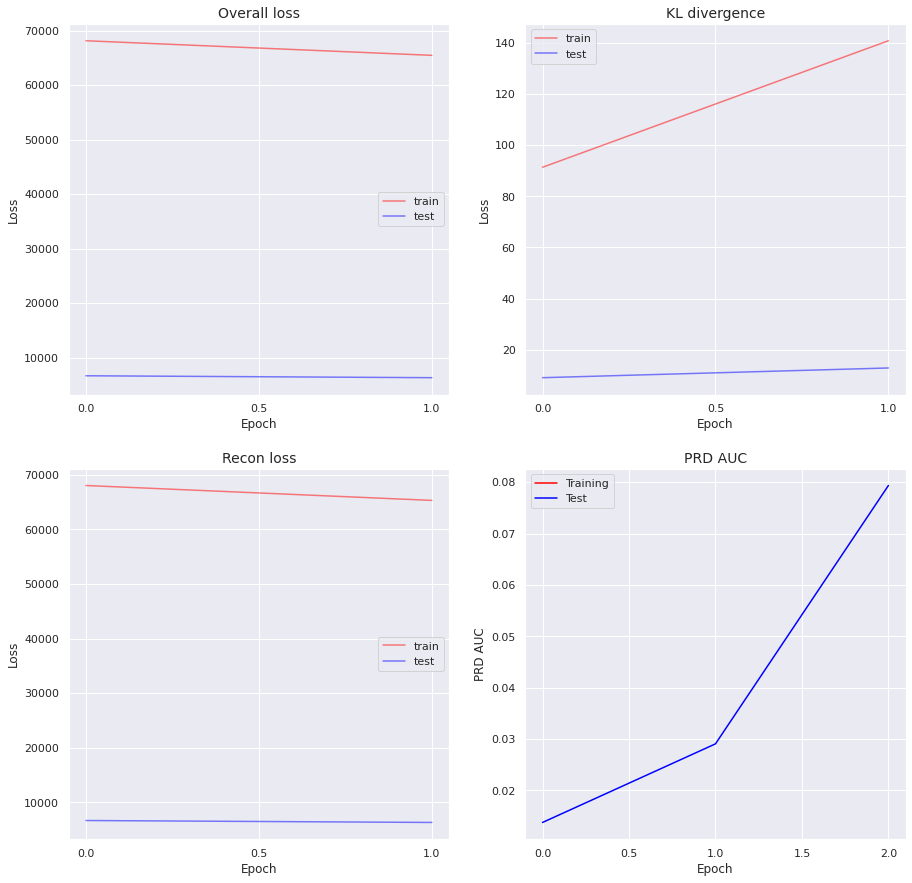

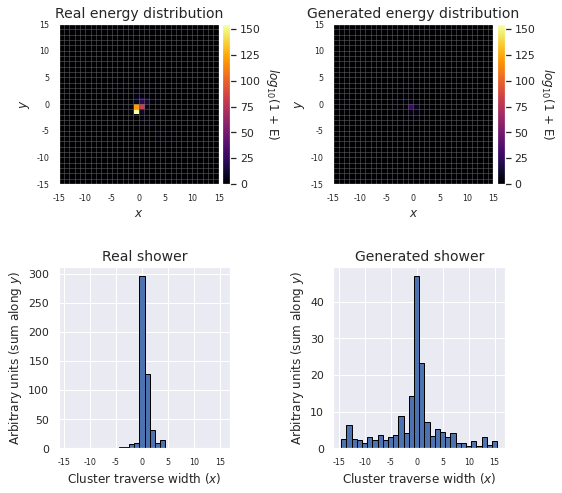

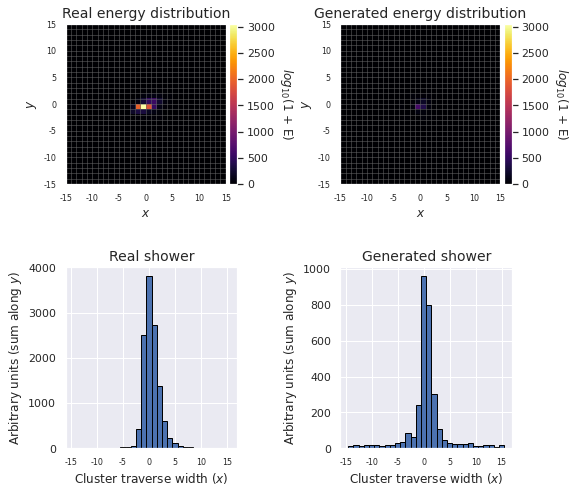

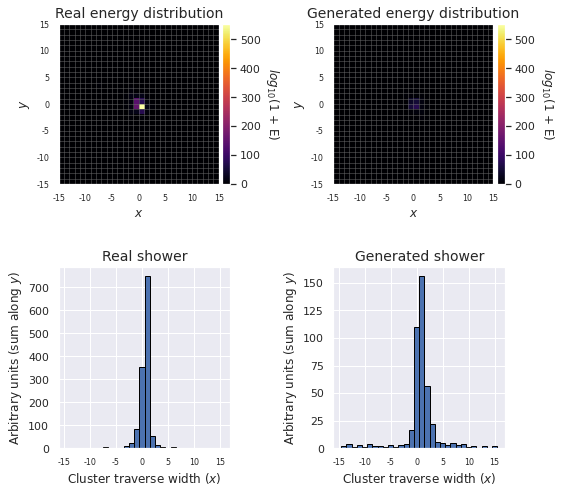

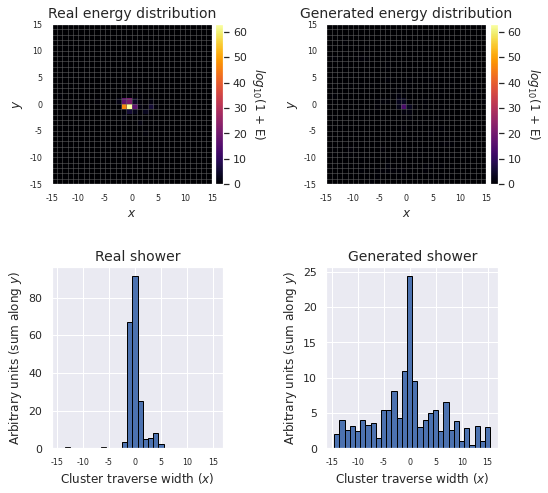

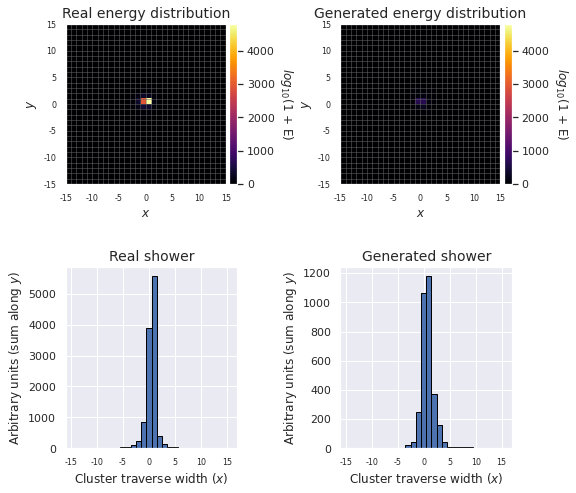

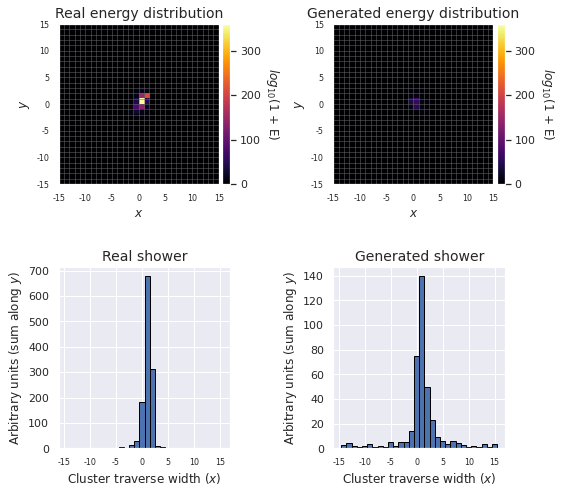

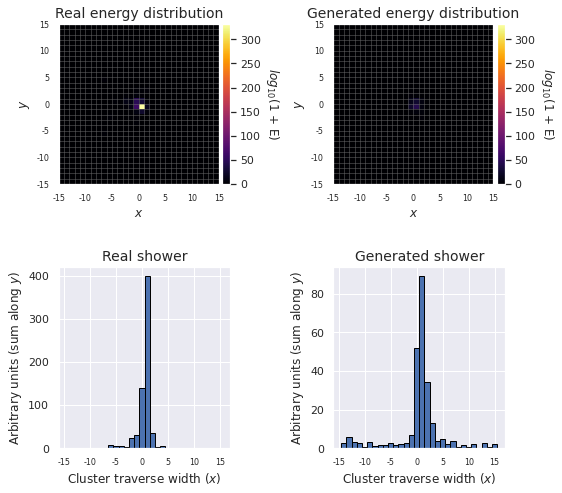

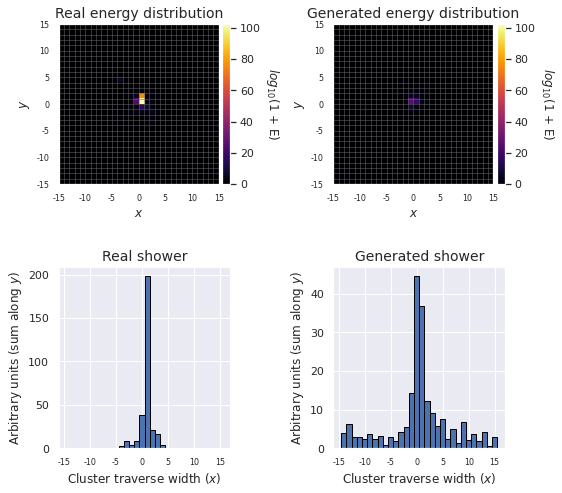

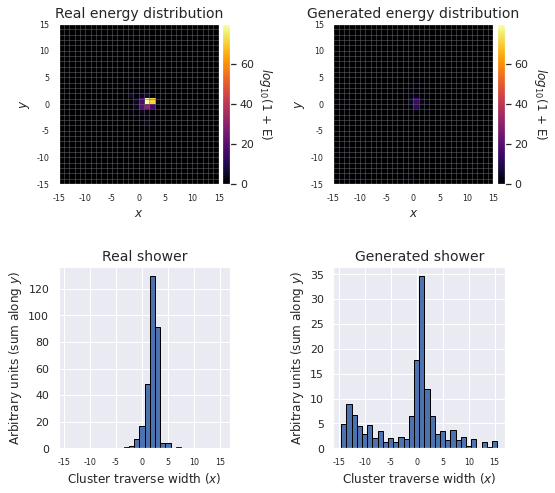

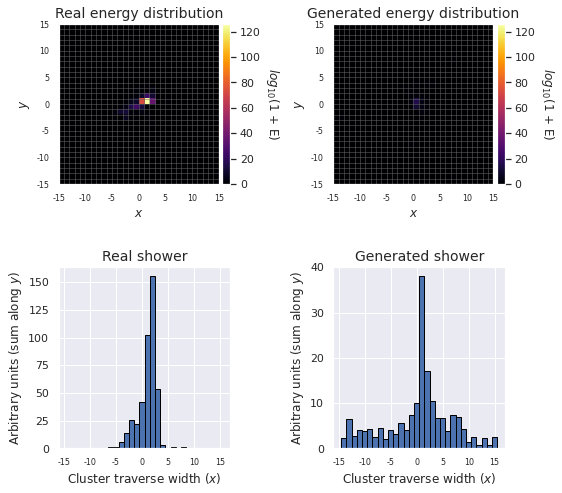

100%|██████████| 3/3 [28:55<00:00, 578.51s/it]


In [15]:
max_prd, best_state, prd_auc_test = run_training(3)